In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/My Drive/TF2/object_detection.zip' -d '/content/drive/My Drive/TF2'

In [ ]:
!pip install tf-models-official
!pip install tf-slim
!pip install lvis

In [ ]:
%cd '/content/drive/My Drive/TF2/object_detection'

In [ ]:
!python model_main_tf2.py --pipeline_config_path=training/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config --model_dir=training --alsologtostderr

In [ ]:
!python exporter_main_v2.py --trained_checkpoint_dir=training --pipeline_config_path=training/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config --output_directory inference_graph

In [6]:
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
PATH_TO_MODEL_DIR = "/content/drive/My Drive/TF2/object_detection/inference_graph"
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 11.223567008972168 seconds


In [7]:
category_index = label_map_util.create_category_index_from_labelmap("/content/drive/My Drive/TF2/object_detection/training/labelmap.pbtxt",use_display_name=True)

In [9]:
import os

def list_image_dir(IMAGE_PATH):
  img = []
  for file_name in os.listdir(IMAGE_PATH):
    if ('.jpg' in file_name) or ('.png' in file_name):
      img.append(os.path.join(IMAGE_PATH,file_name))
  return img
IMAGE_DIR = '/content/drive/My Drive/TF2/object_detection/images/test'
list_image_dir(IMAGE_DIR)

['/content/drive/My Drive/TF2/object_detection/images/test/i-07d09c281bd94e88af9a4e3811e976e4.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-c55a624481f64660a4a6721f6e1ba765.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-fbc3c593f37147b1b90920ca7e5e5af3.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-1e092ec6eabf47f9b85795a9e069181b.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-3e7d87c0bc154f93a8d939439277fafc.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-98d05f7a289847b7b166272d70025f5f.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-038215c28fdc4e55be33235cf3bf8fcd.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-aec5aed72f4d43fab8957c948eb625d3.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-14370c36306d44cfbb37232f766e0365.jpg',
 '/content/drive/My Drive/TF2/object_detection/images/test/i-29c86b783ec244acba67b45d5f16ded1.jpg']

Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-07d09c281bd94e88af9a4e3811e976e4.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-c55a624481f64660a4a6721f6e1ba765.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-fbc3c593f37147b1b90920ca7e5e5af3.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-1e092ec6eabf47f9b85795a9e069181b.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-3e7d87c0bc154f93a8d939439277fafc.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-98d05f7a289847b7b166272d70025f5f.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-038215c28fdc4e55be33235cf3bf8fcd.jpg... Done
Running inference for /content/drive/My Drive/TF2/object_detection/images/test/i-aec5aed72f4d43fab8957c948eb625d3.jpg.

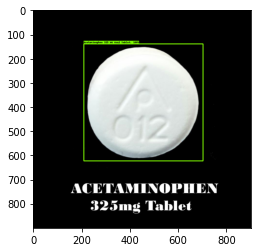

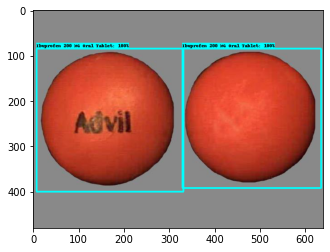

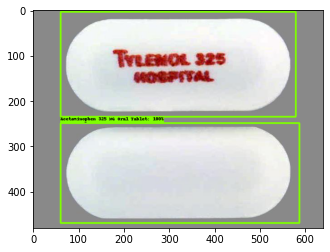

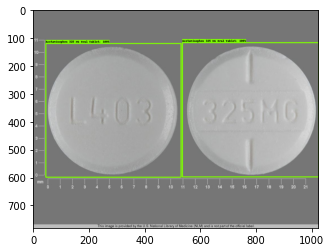

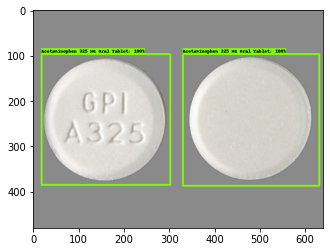

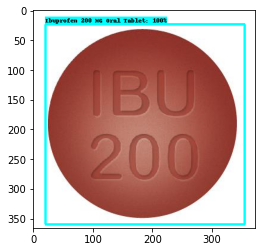

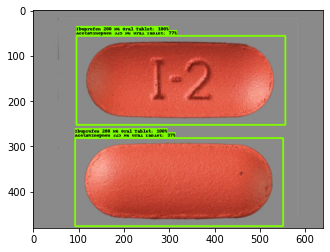

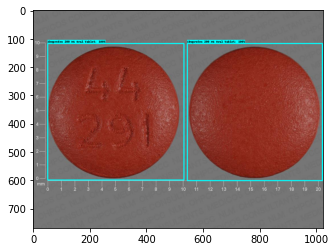

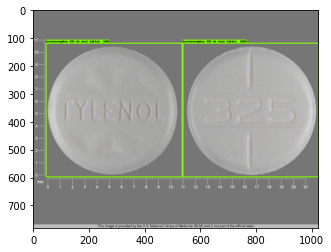

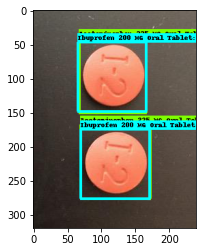

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in list_image_dir(IMAGE_DIR):

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2